------------------------------
Stats for a.in
World: 5x4, 5 steps
Tasks number: 3
Arms number: 2
Mount points number: 3
Sum of scores (max score):  16
Average task score: 5.333333333333333
Sum of task assembly points number:  4
Average assembly points number:  1.3333333333333333
Average task route length (L1 sum + dist to closest MP): 2.3333333333333335


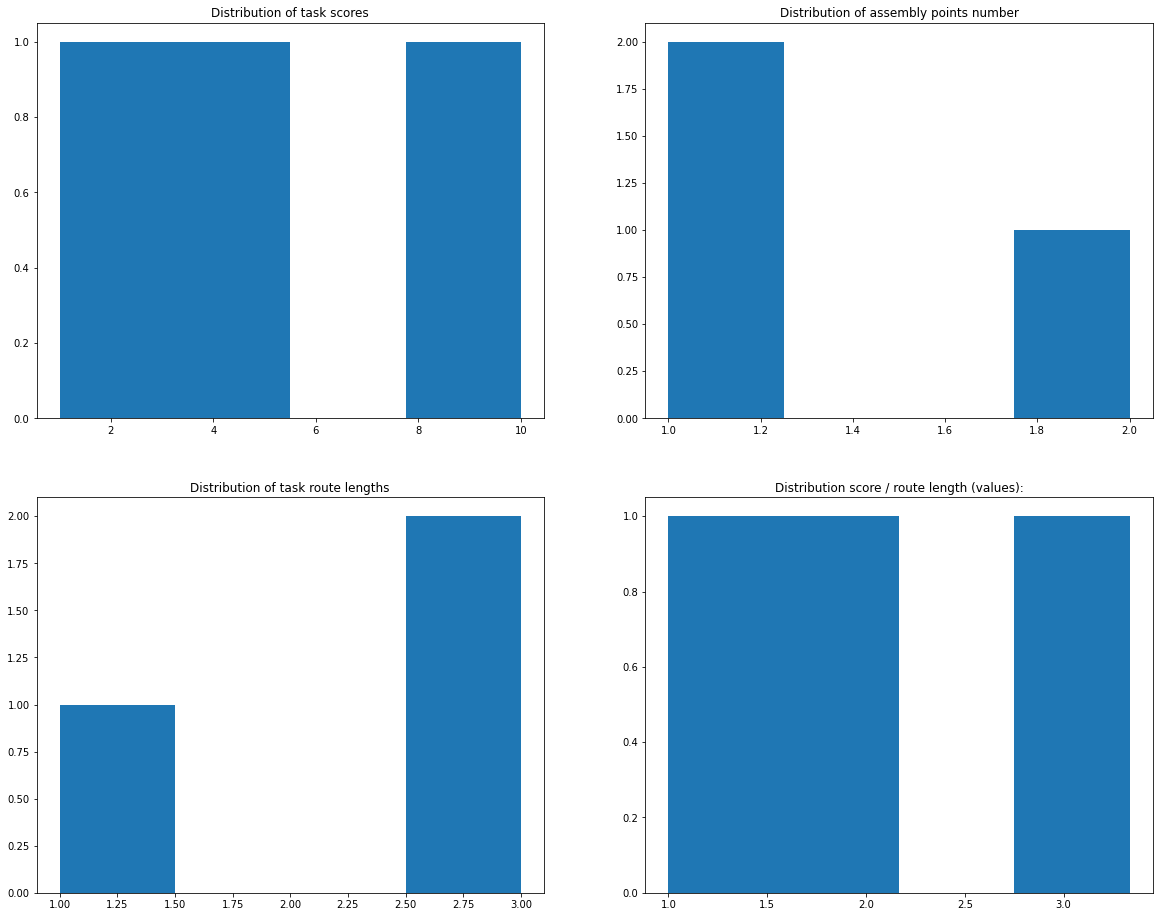

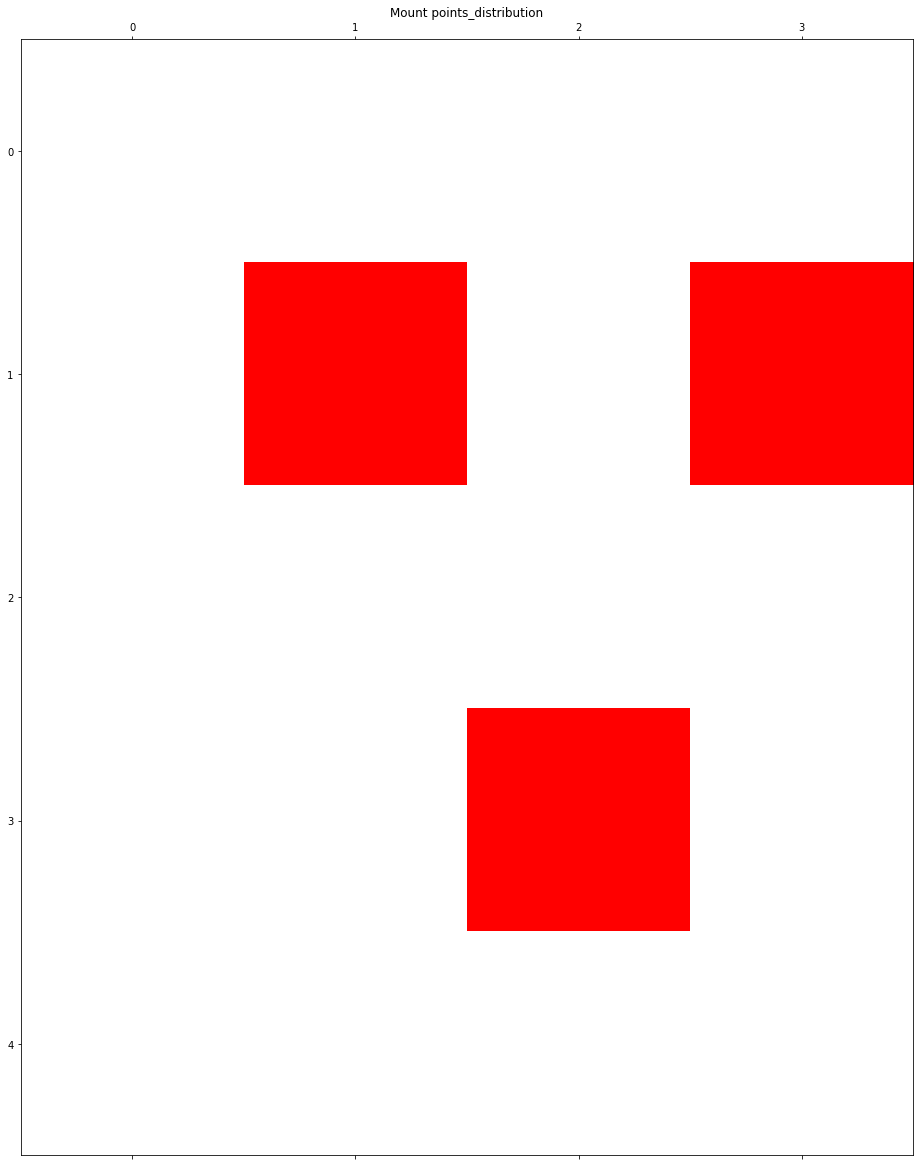

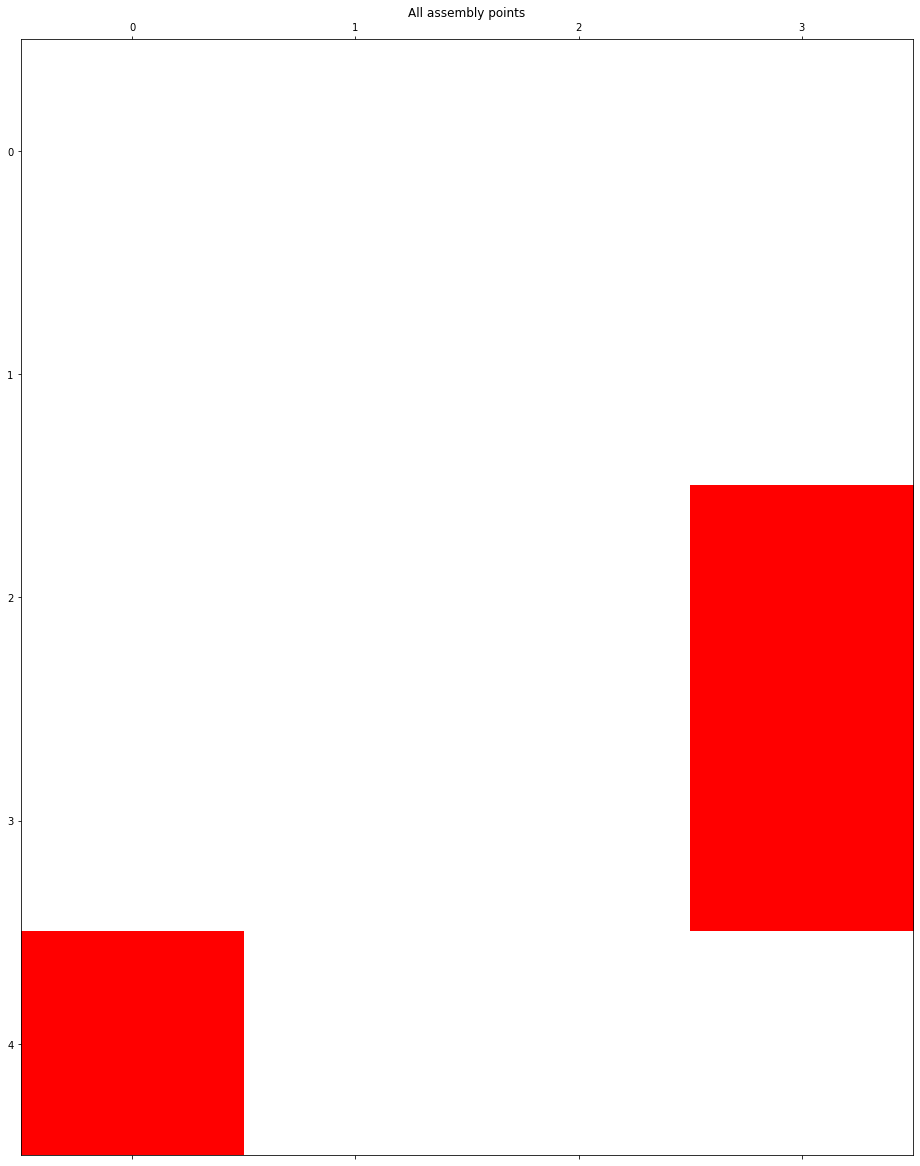

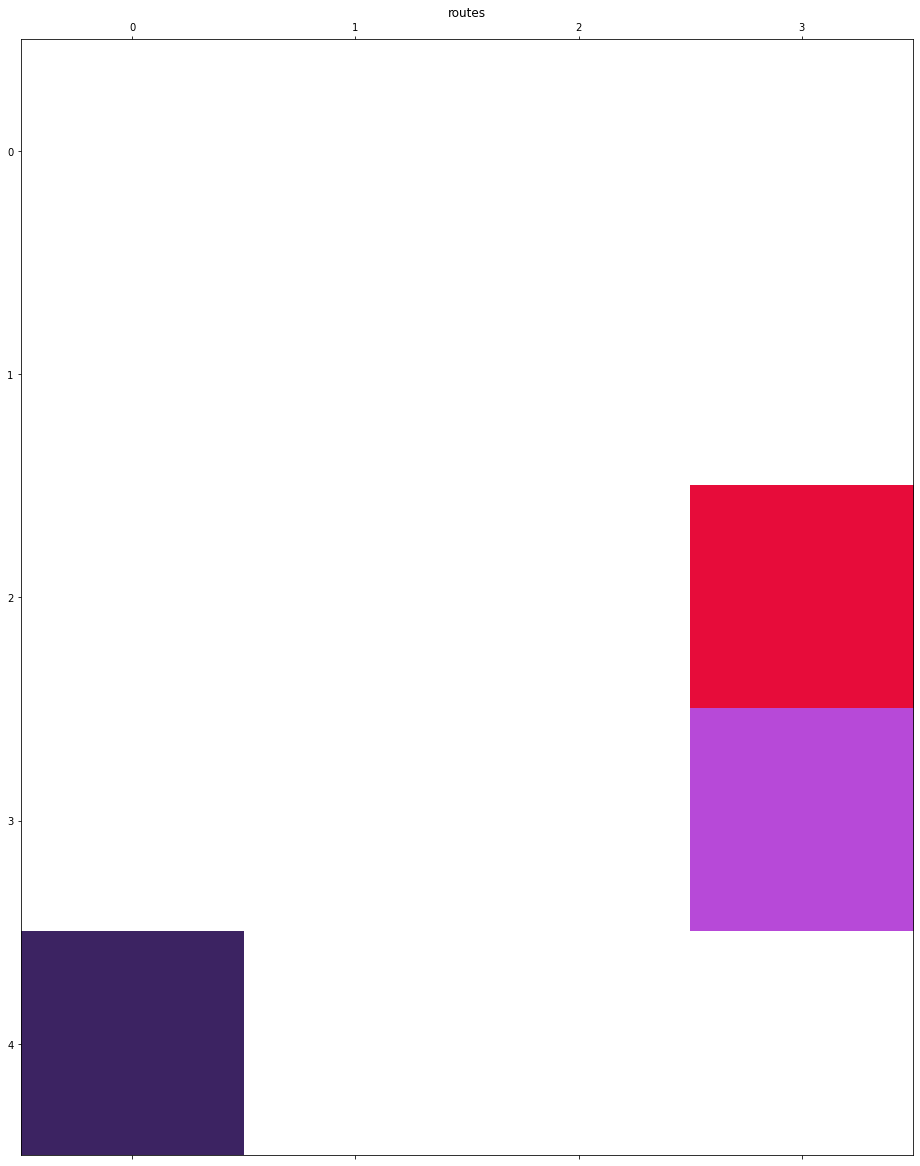




------------------------------
Stats for b.in
World: 100x100, 10000 steps
Tasks number: 1000
Arms number: 1
Mount points number: 10
Sum of scores (max score):  1070068
Average task score: 1070.068
Sum of task assembly points number:  1000
Average assembly points number:  1.0
Average task route length (L1 sum + dist to closest MP): 70.486


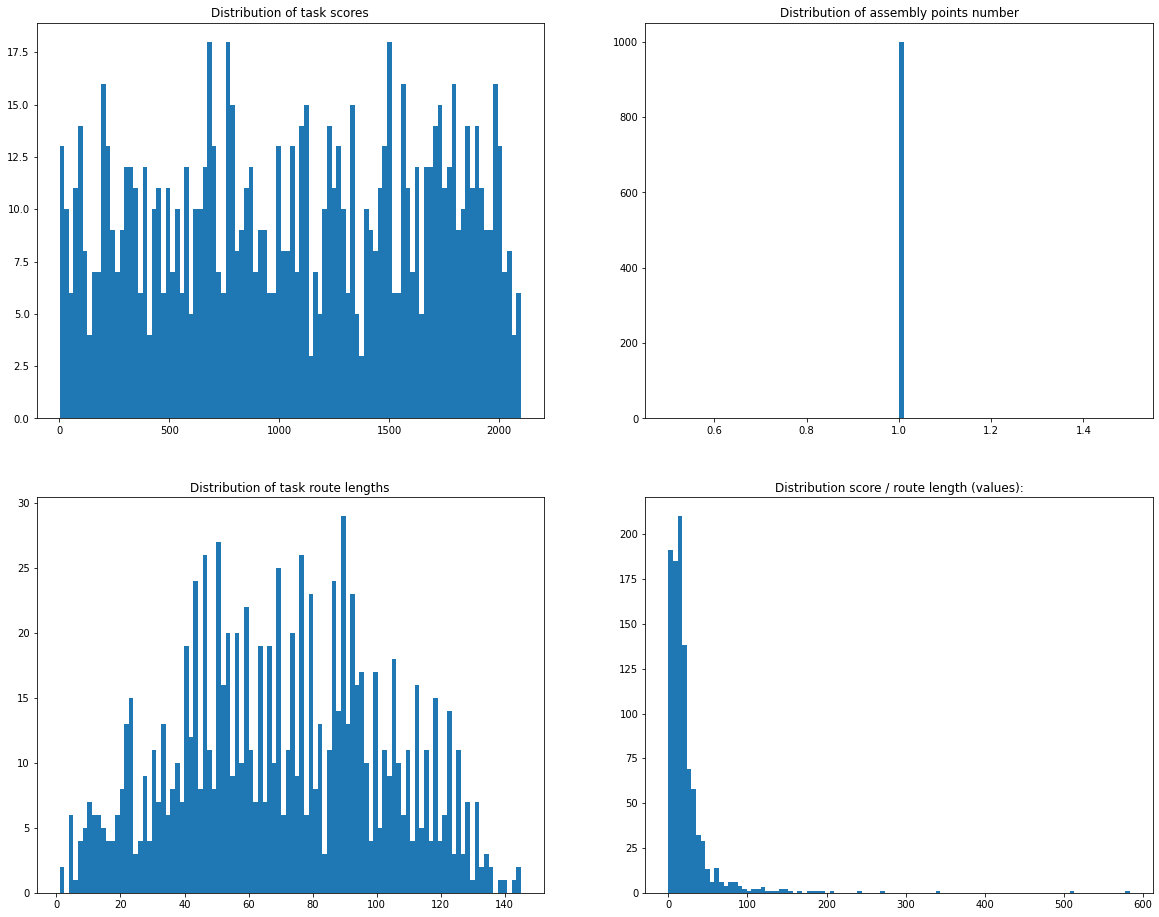

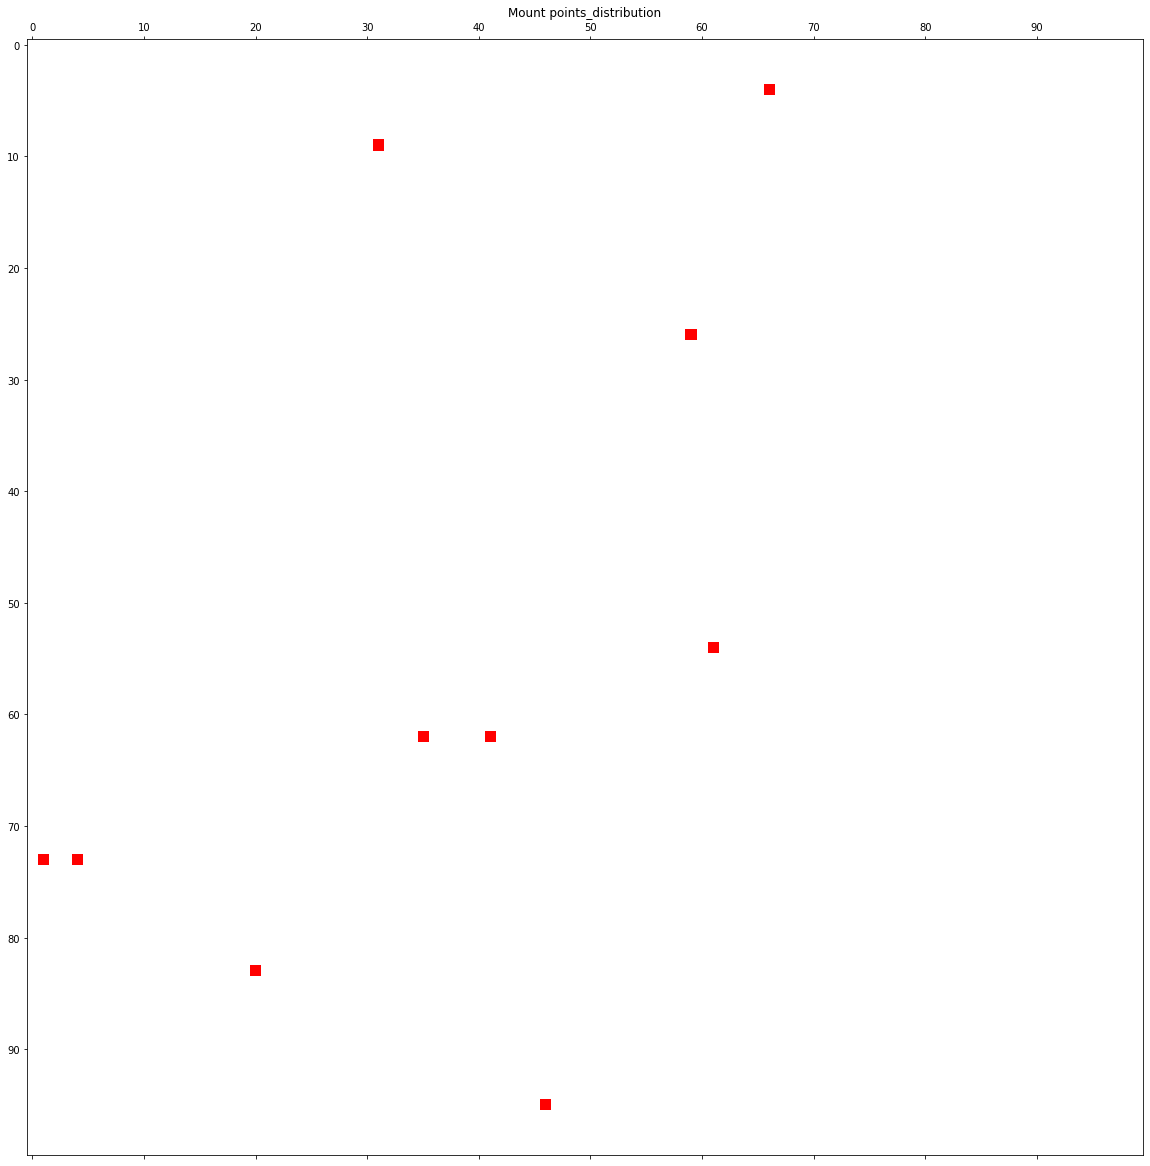

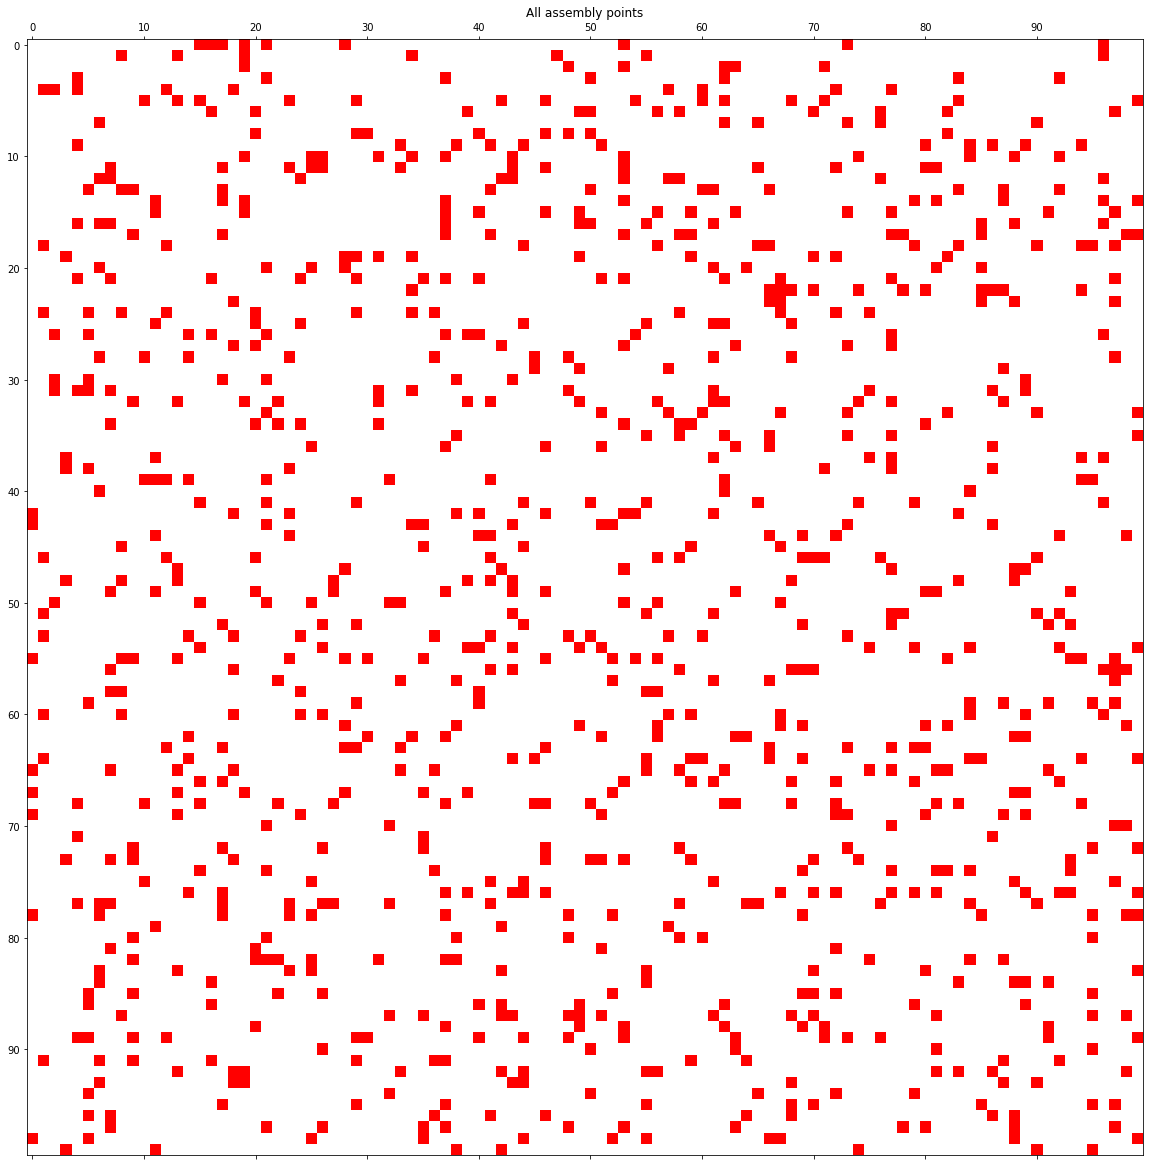

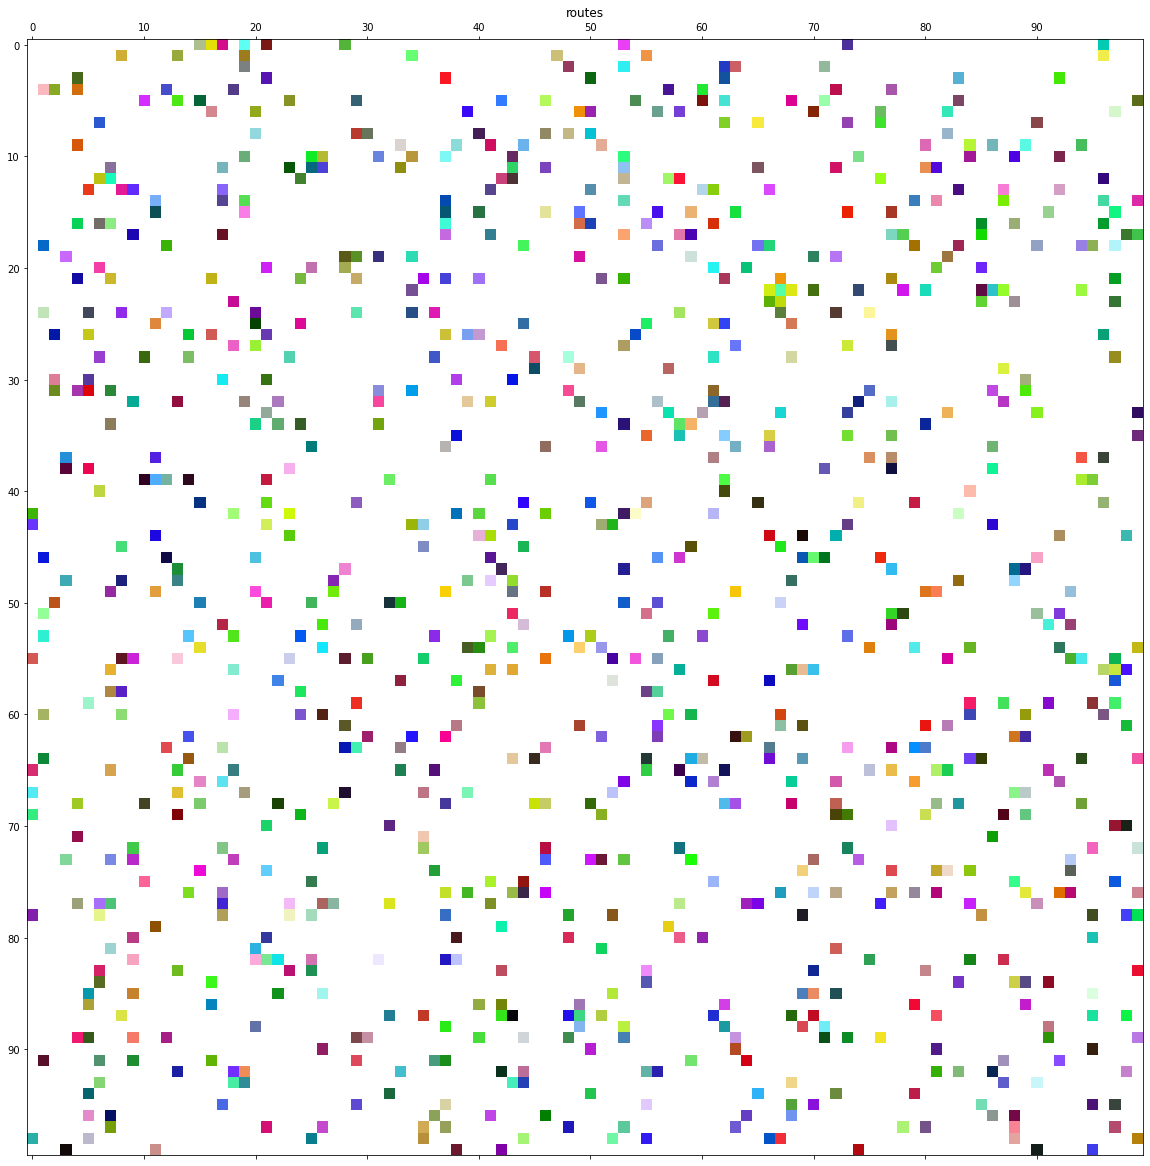




------------------------------
Stats for c.in
World: 500x500, 10000 steps
Tasks number: 100
Arms number: 10
Mount points number: 1000
Sum of scores (max score):  3527457
Average task score: 35274.57
Sum of task assembly points number:  2410
Average assembly points number:  24.1
Average task route length (L1 sum + dist to closest MP): 3310.75


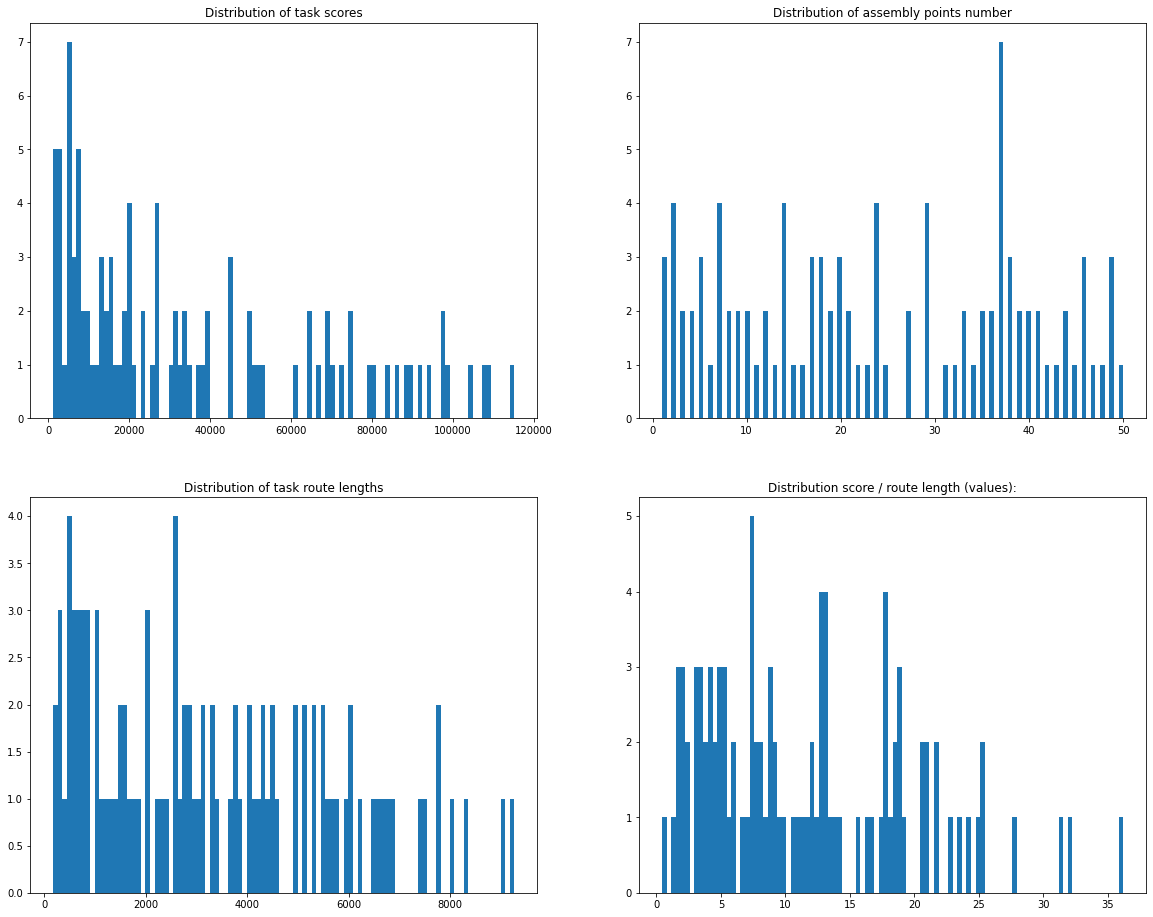

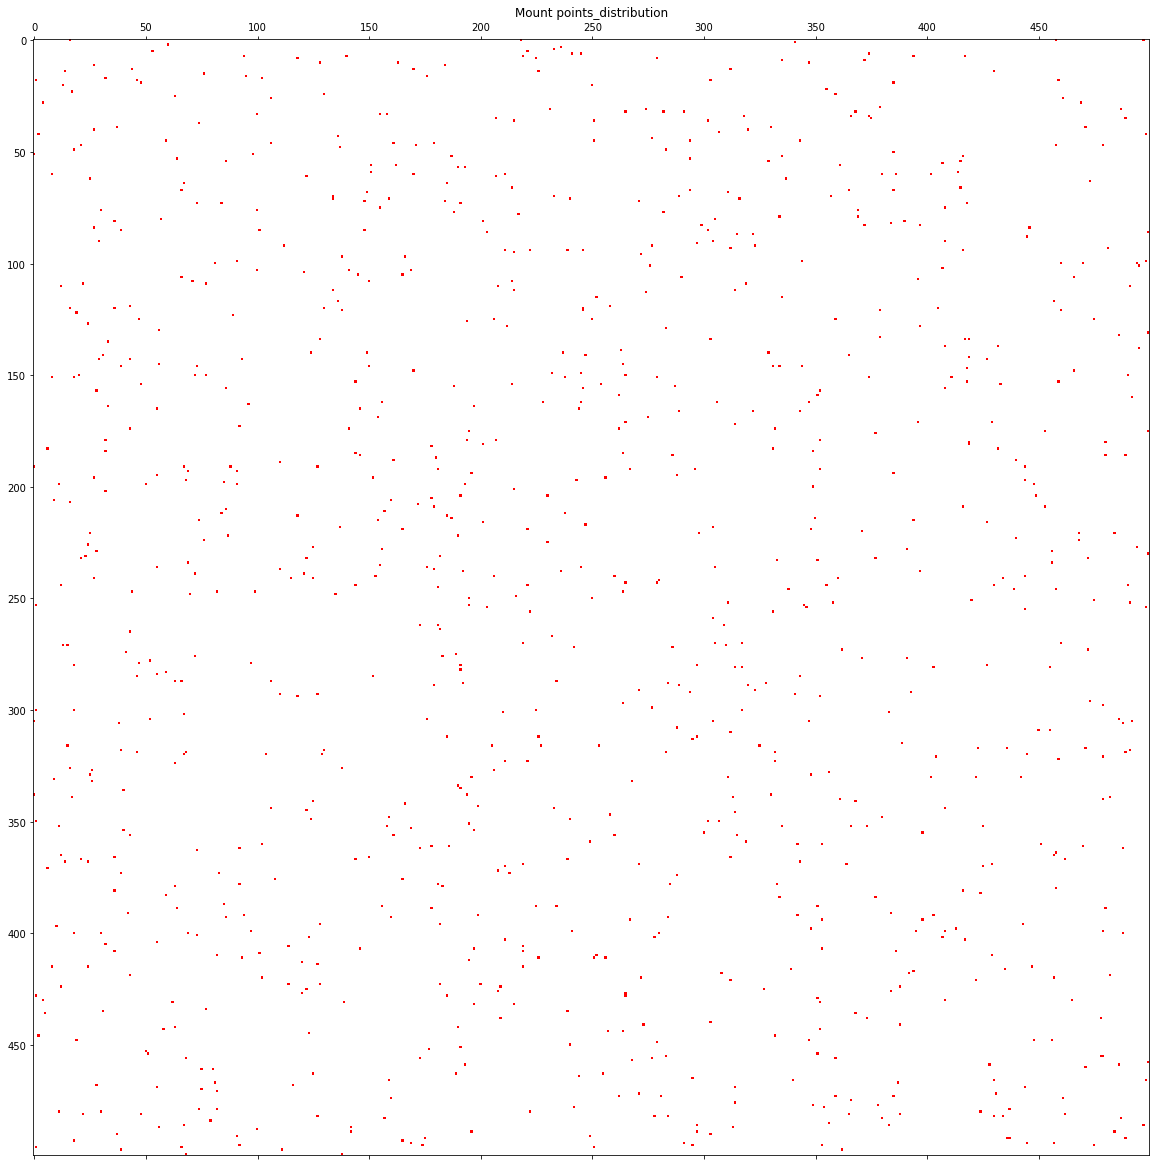

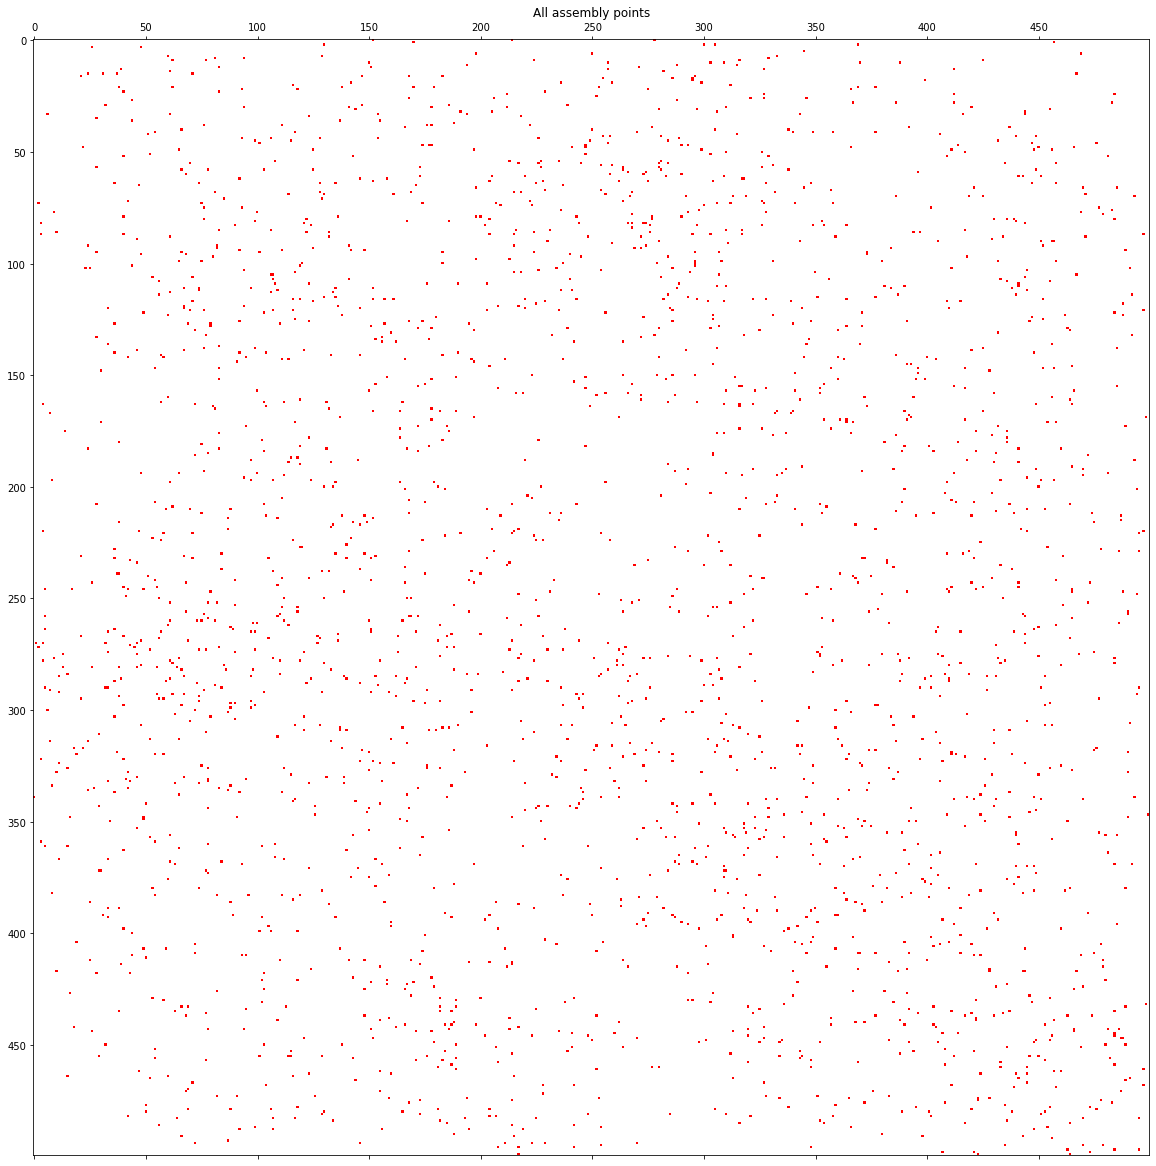

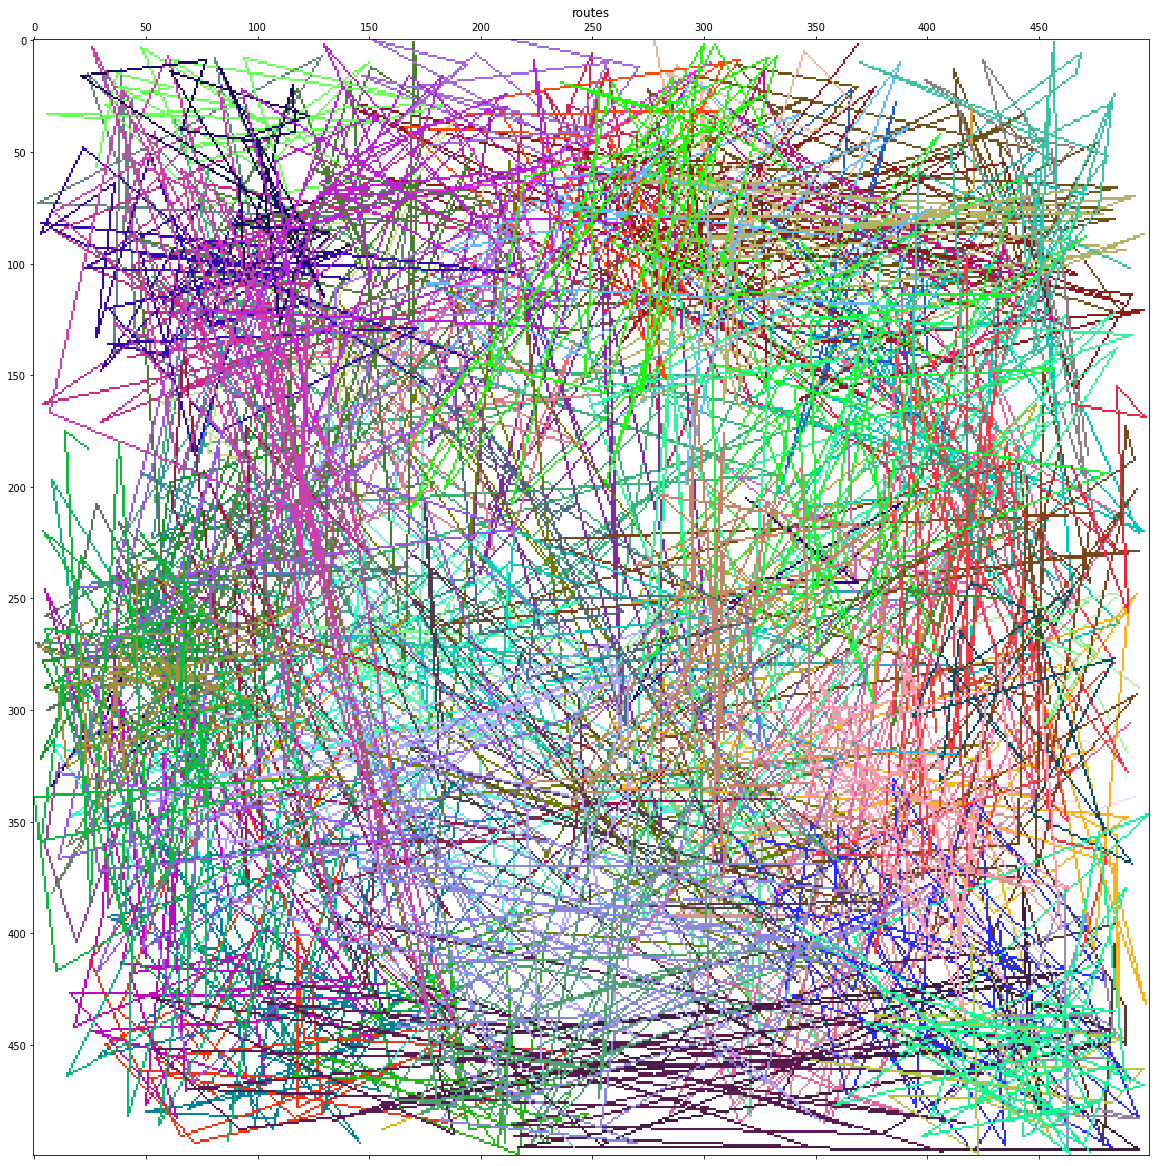




------------------------------
Stats for d.in
World: 100x100, 200 steps
Tasks number: 1000
Arms number: 100
Mount points number: 500
Sum of scores (max score):  2594117
Average task score: 2594.117
Sum of task assembly points number:  3006
Average assembly points number:  3.006
Average task route length (L1 sum + dist to closest MP): 114.681


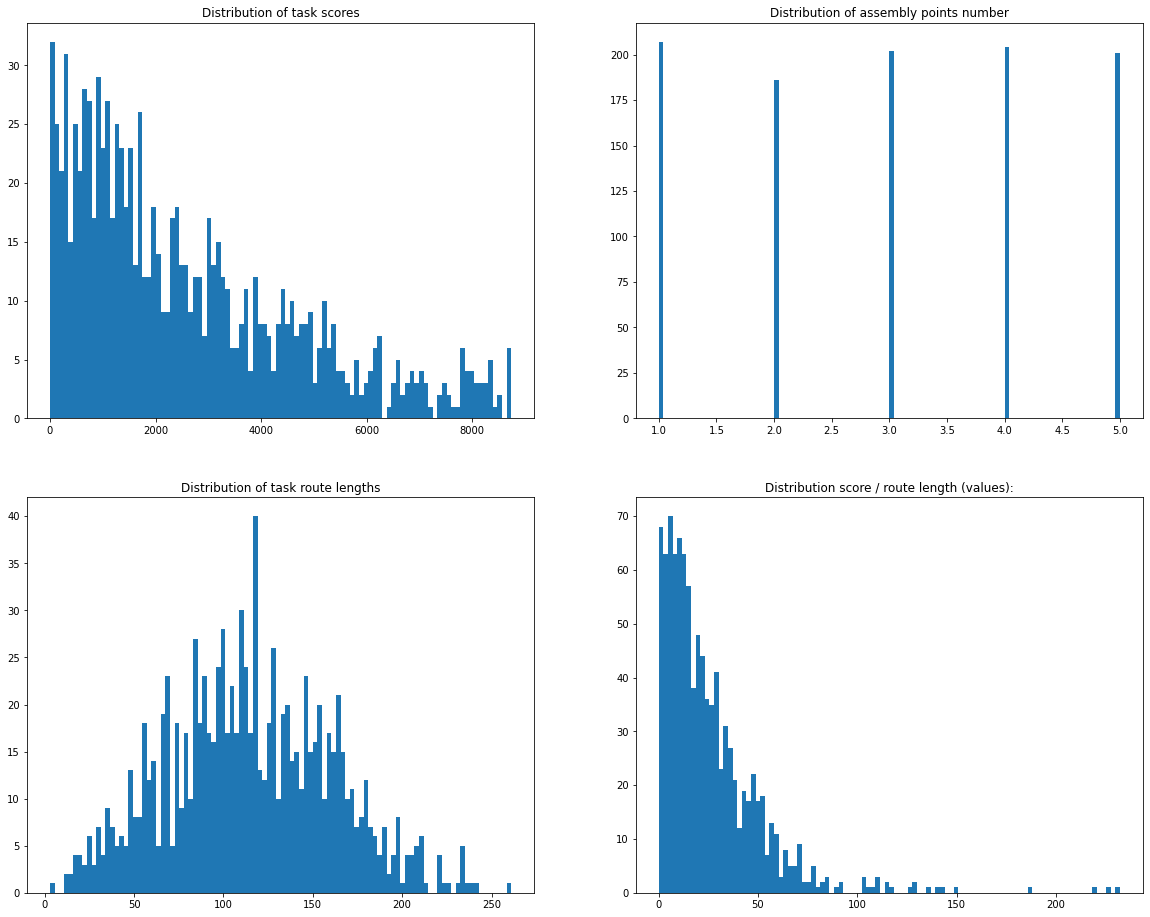

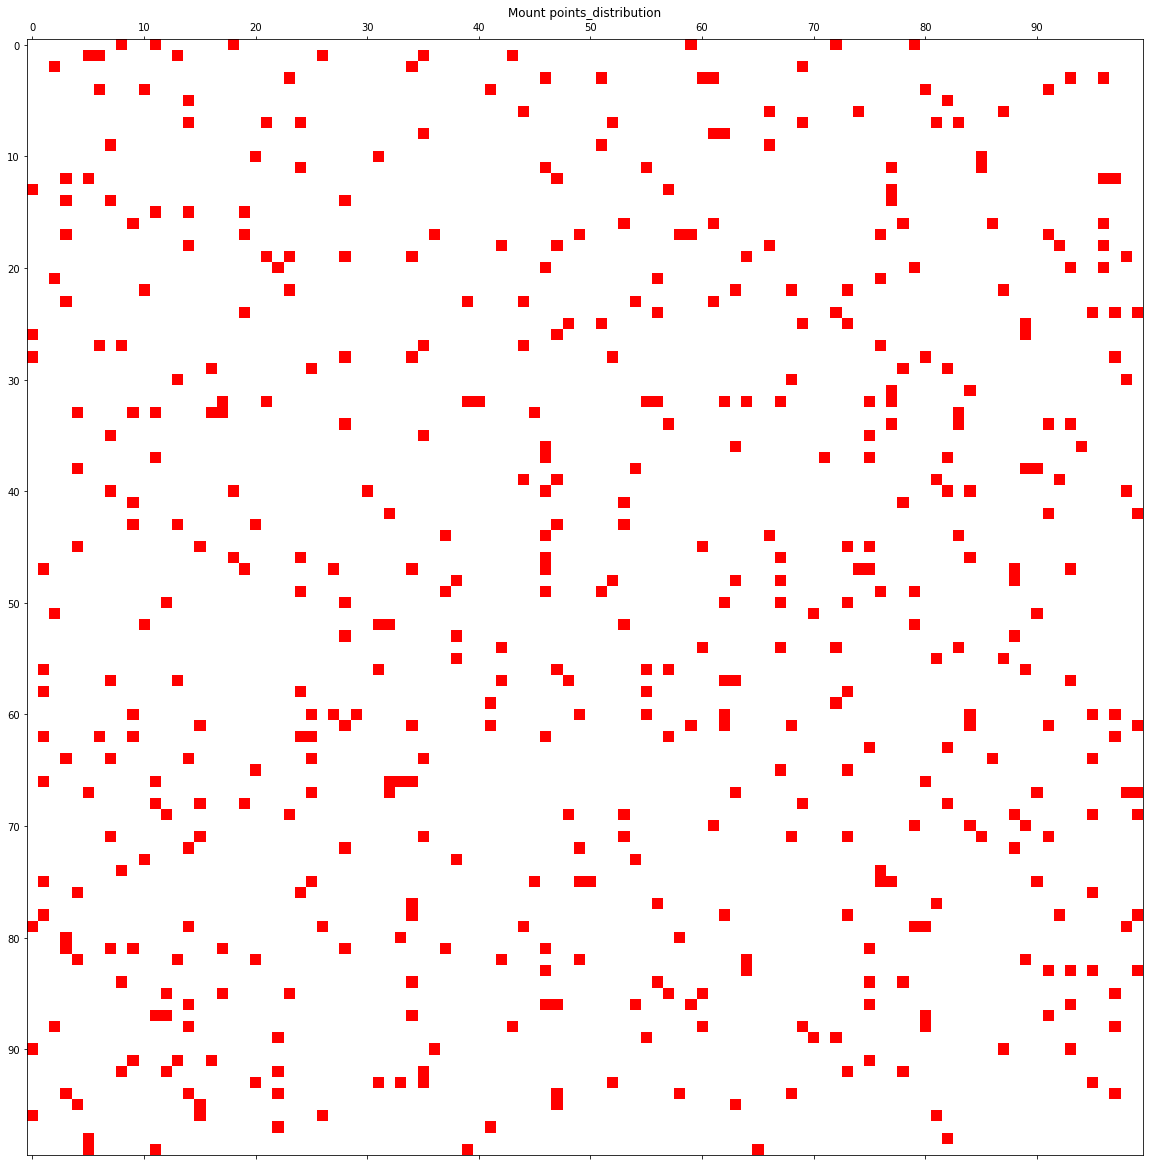

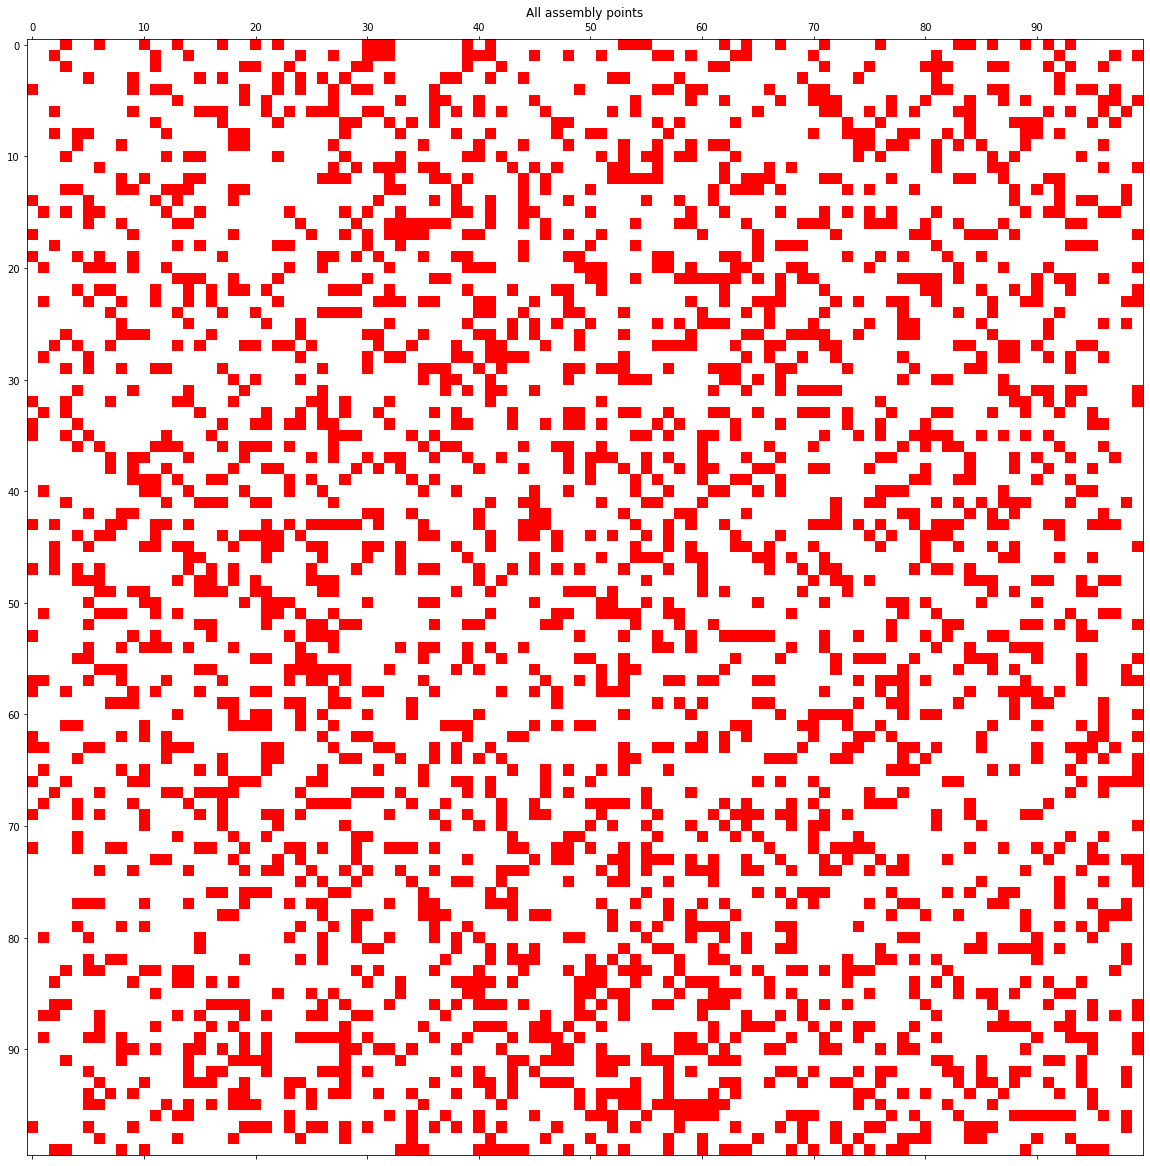

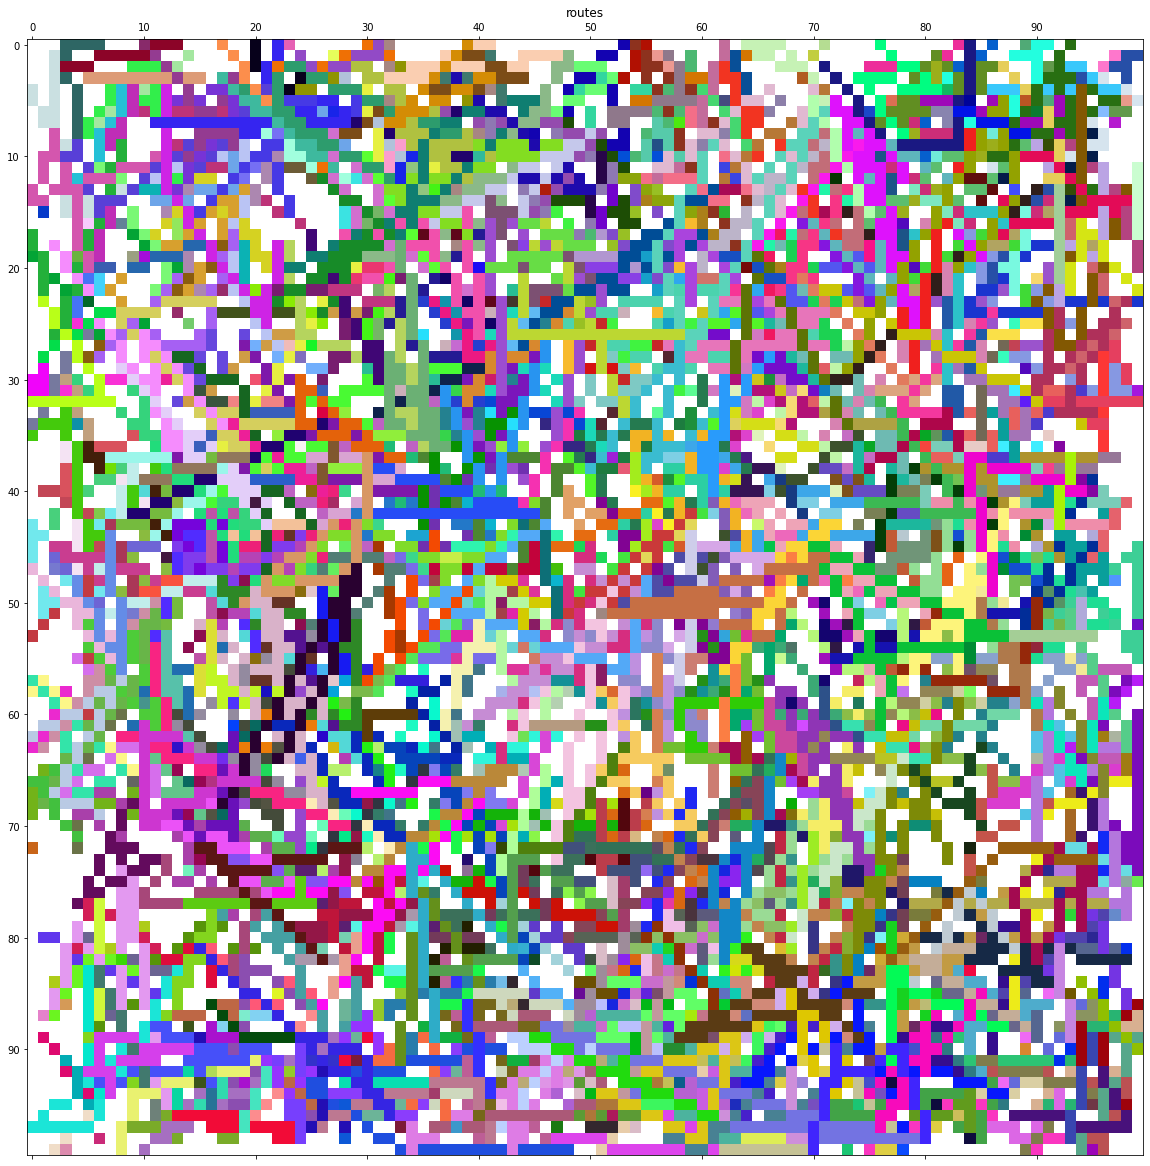




------------------------------
Stats for e.in
World: 100x100, 10000 steps
Tasks number: 1000
Arms number: 100
Mount points number: 1000
Sum of scores (max score):  1105254
Average task score: 1105.254
Sum of task assembly points number:  5469
Average assembly points number:  5.469
Average task route length (L1 sum + dist to closest MP): 163.277


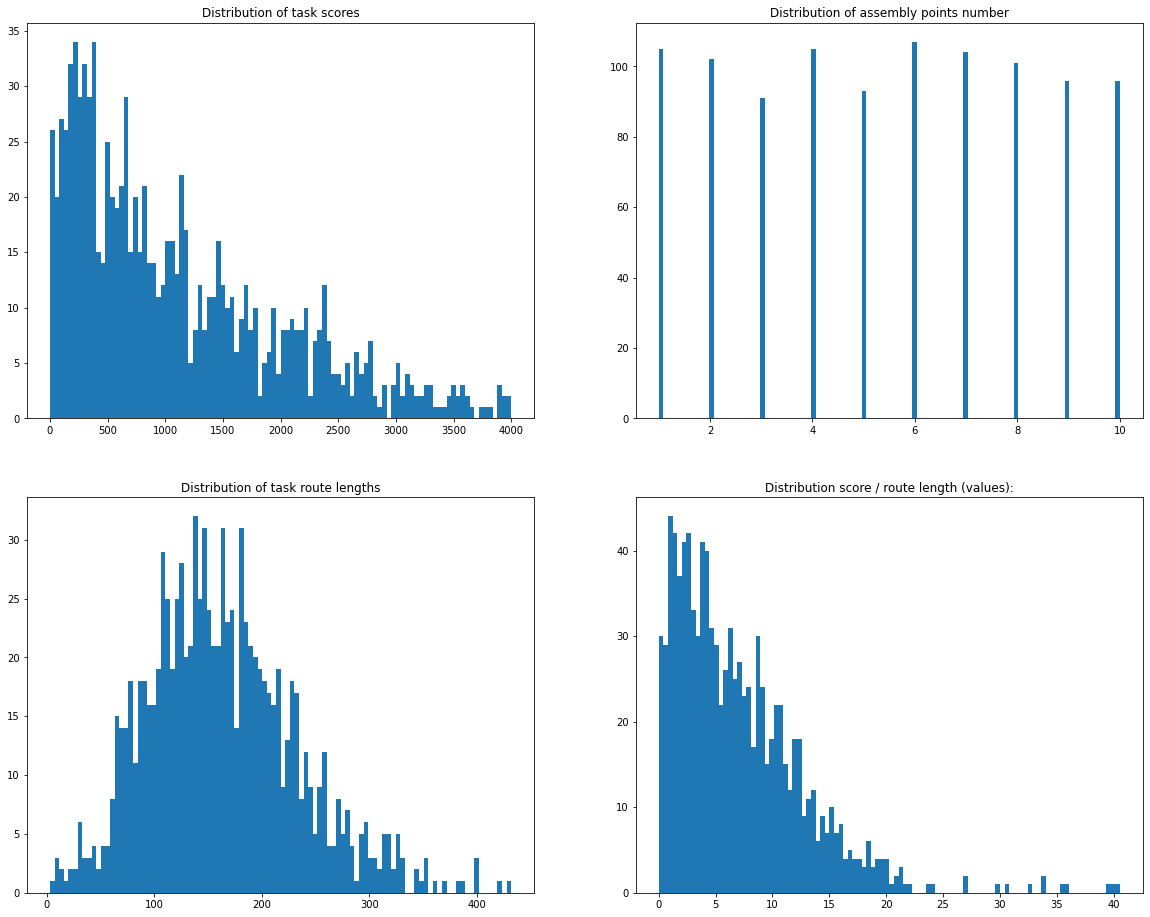

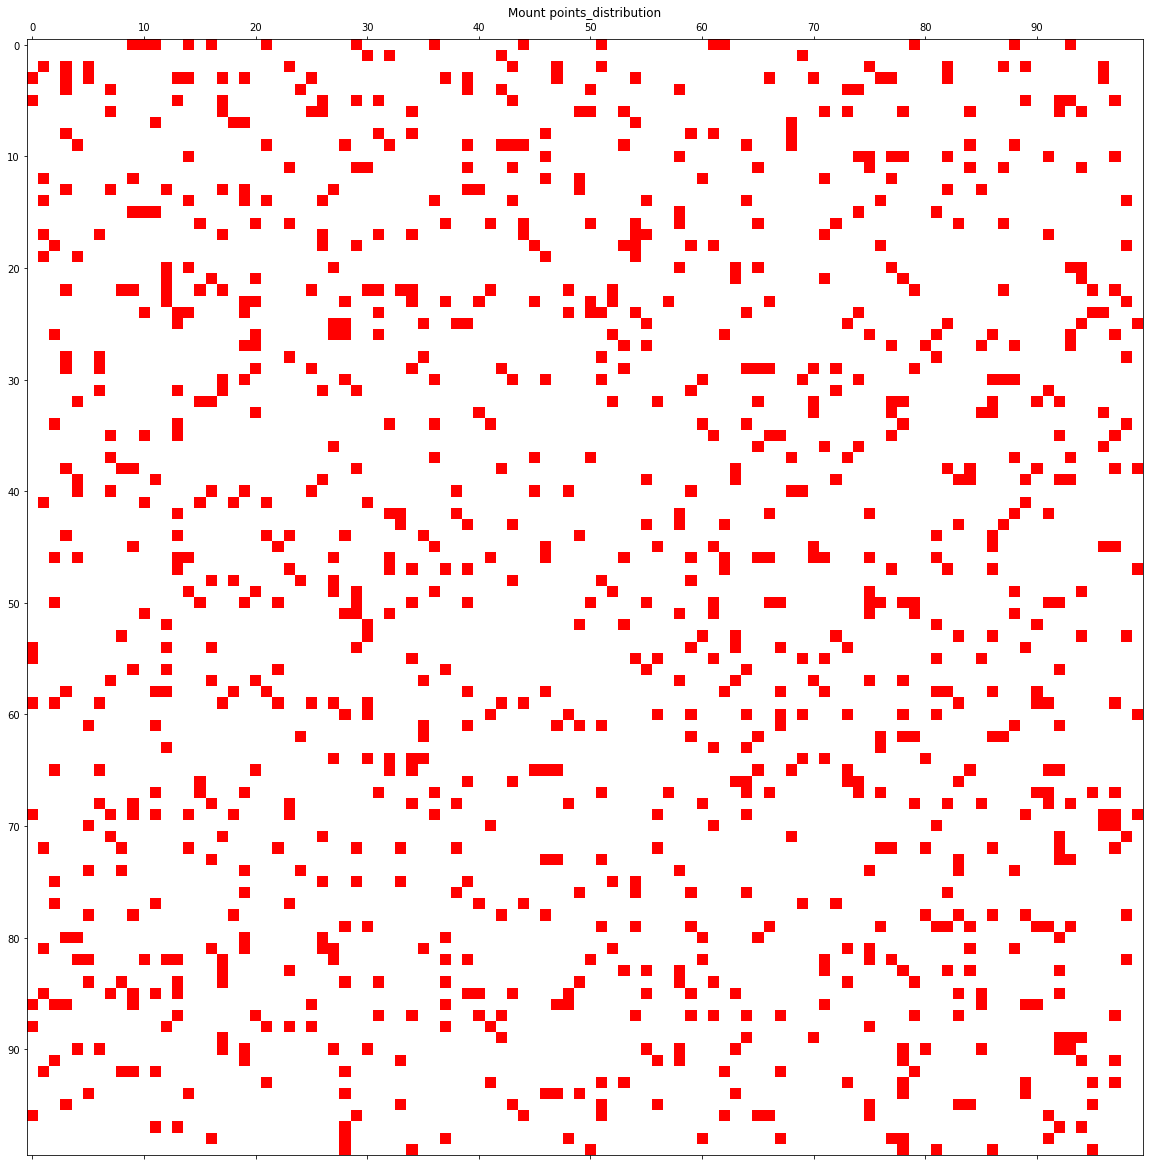

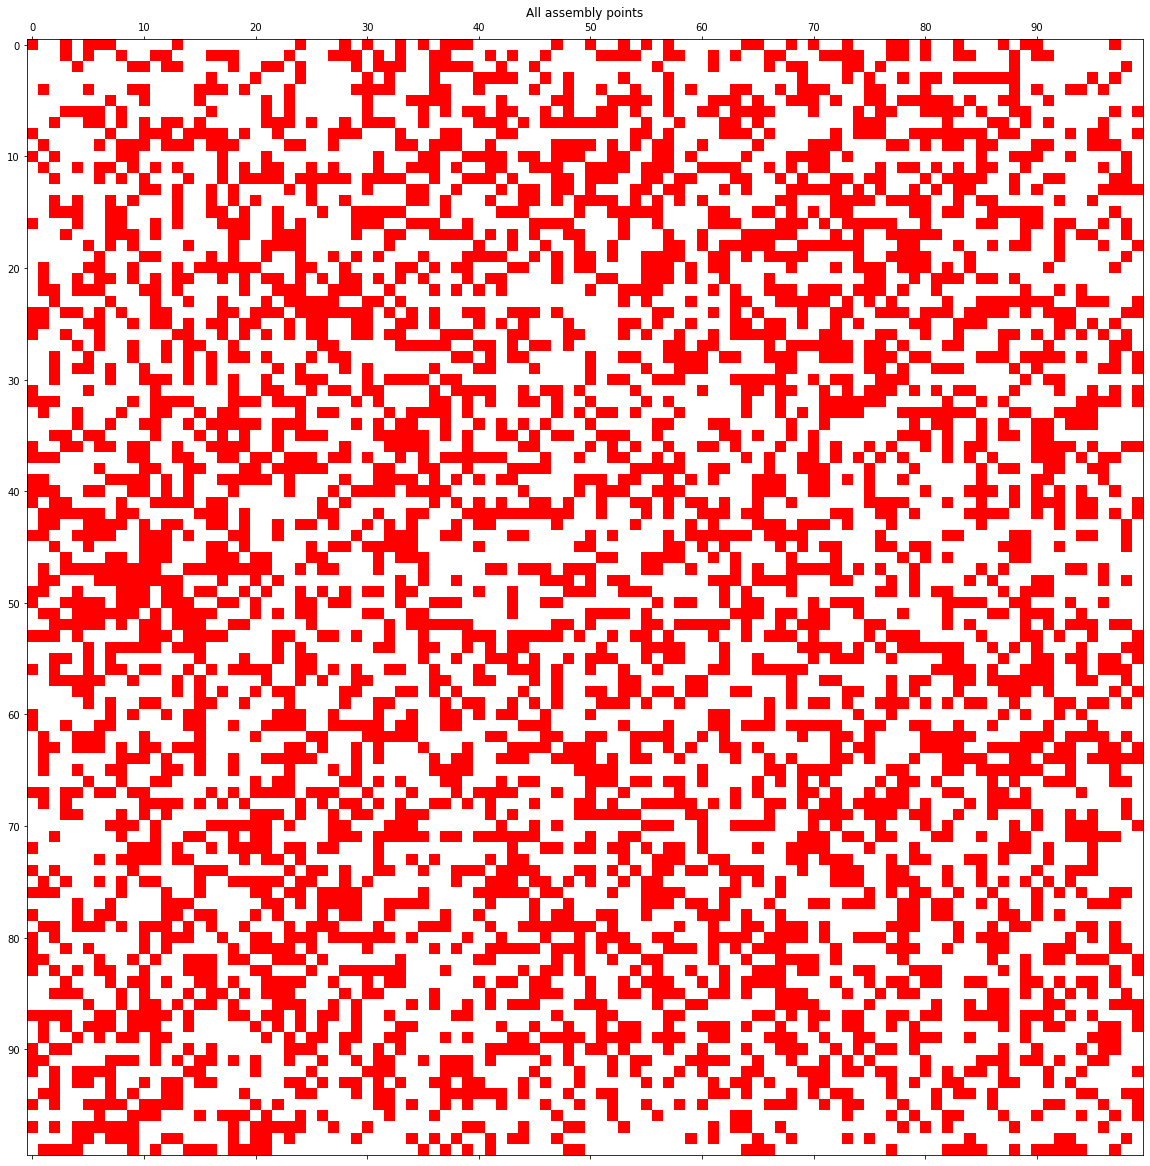

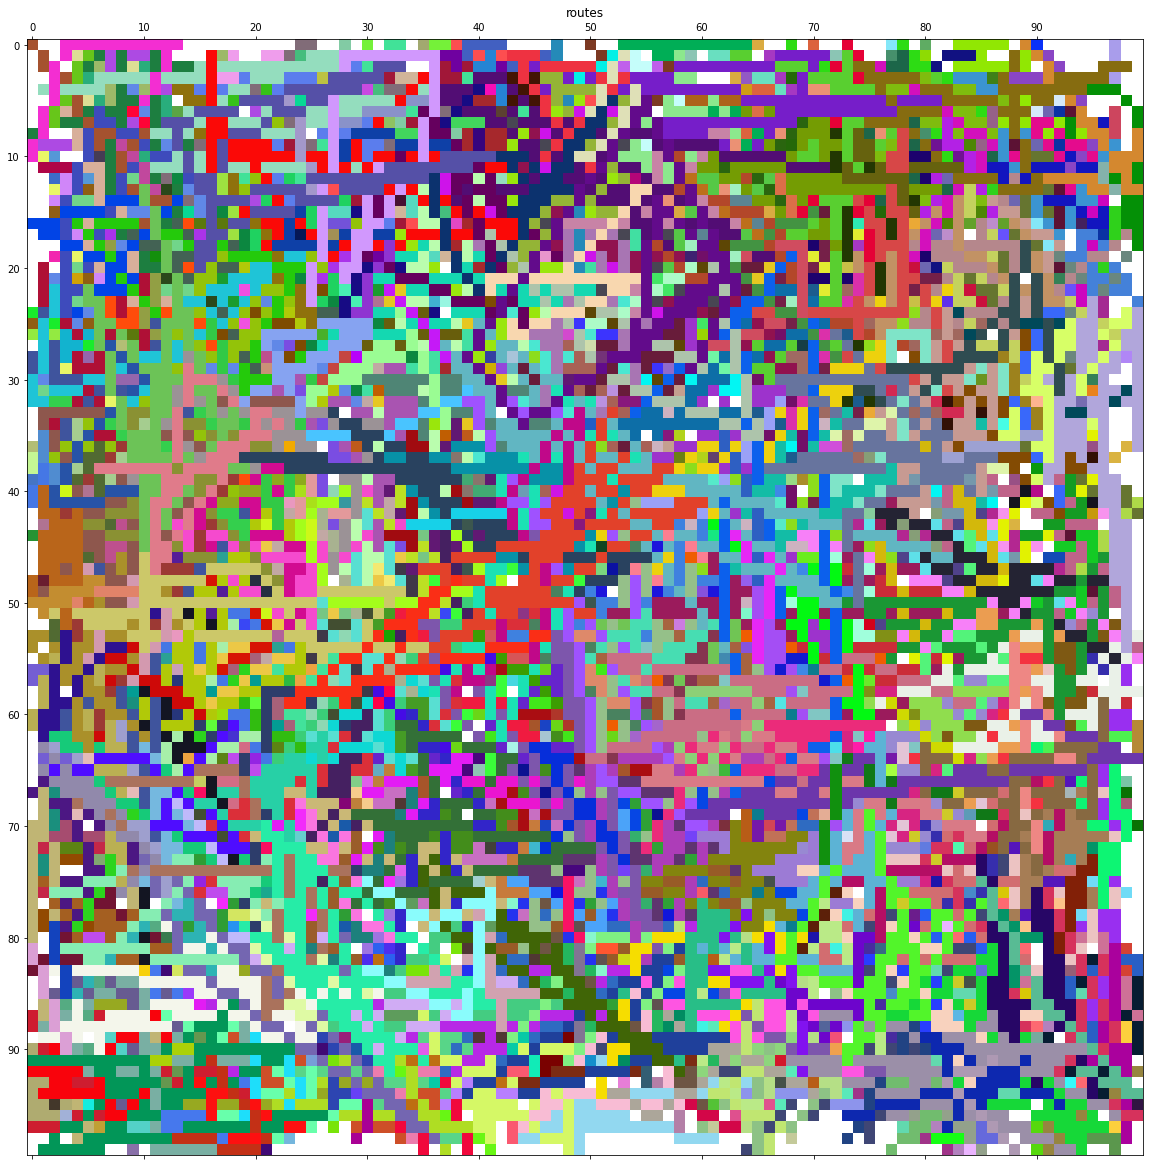




------------------------------
Stats for f.in
World: 300x300, 10000 steps
Tasks number: 1000
Arms number: 50
Mount points number: 100
Sum of scores (max score):  3491888
Average task score: 3491.888
Sum of task assembly points number:  15655
Average assembly points number:  15.655
Average task route length (L1 sum + dist to closest MP): 885.505


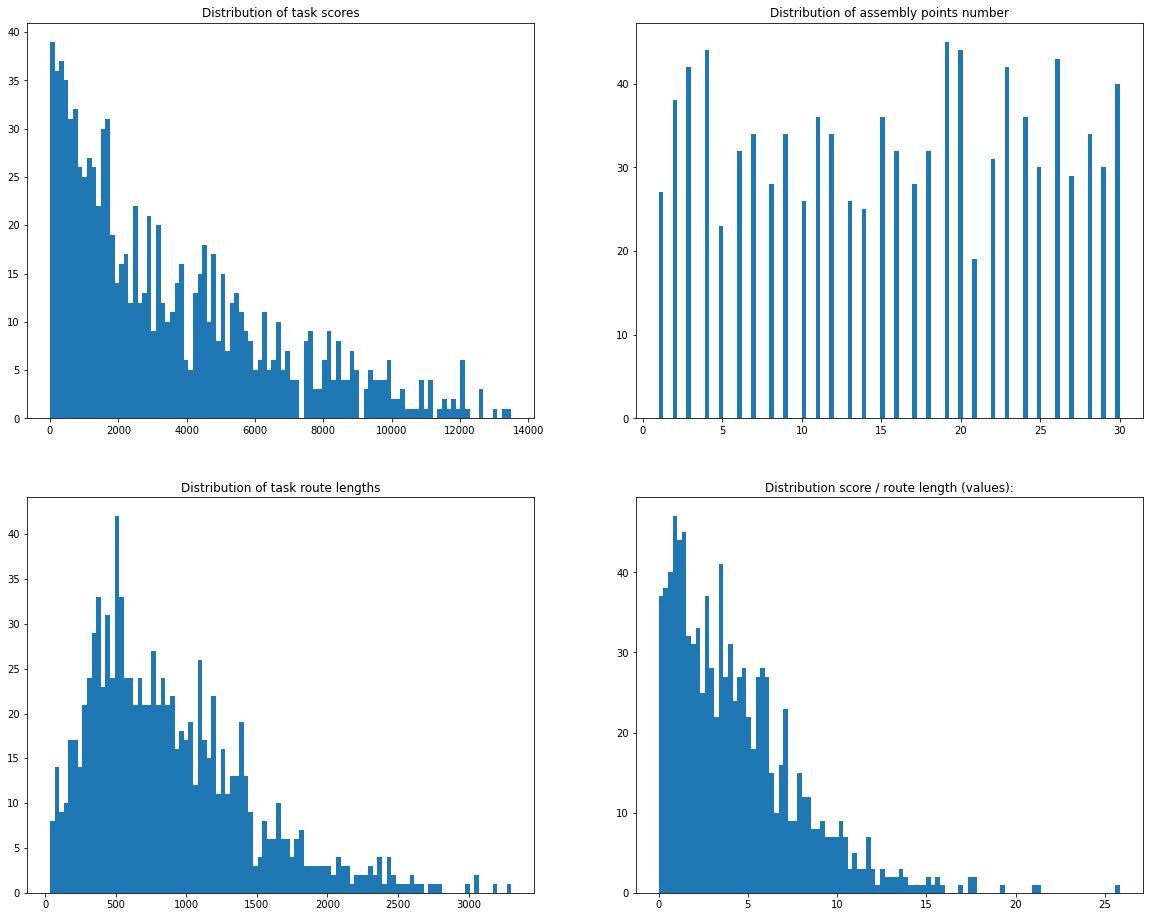

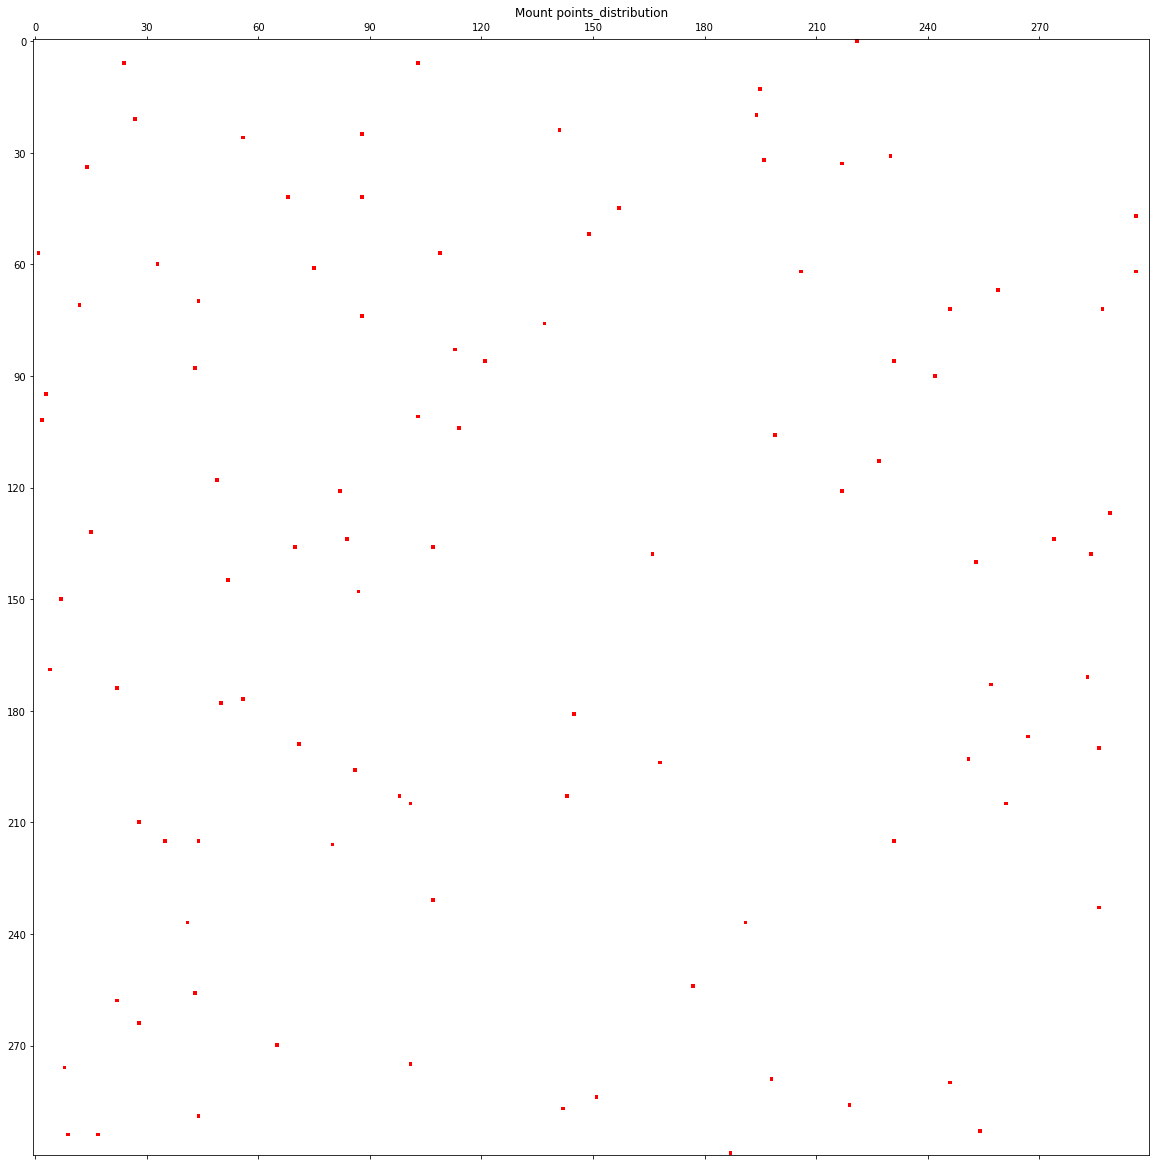

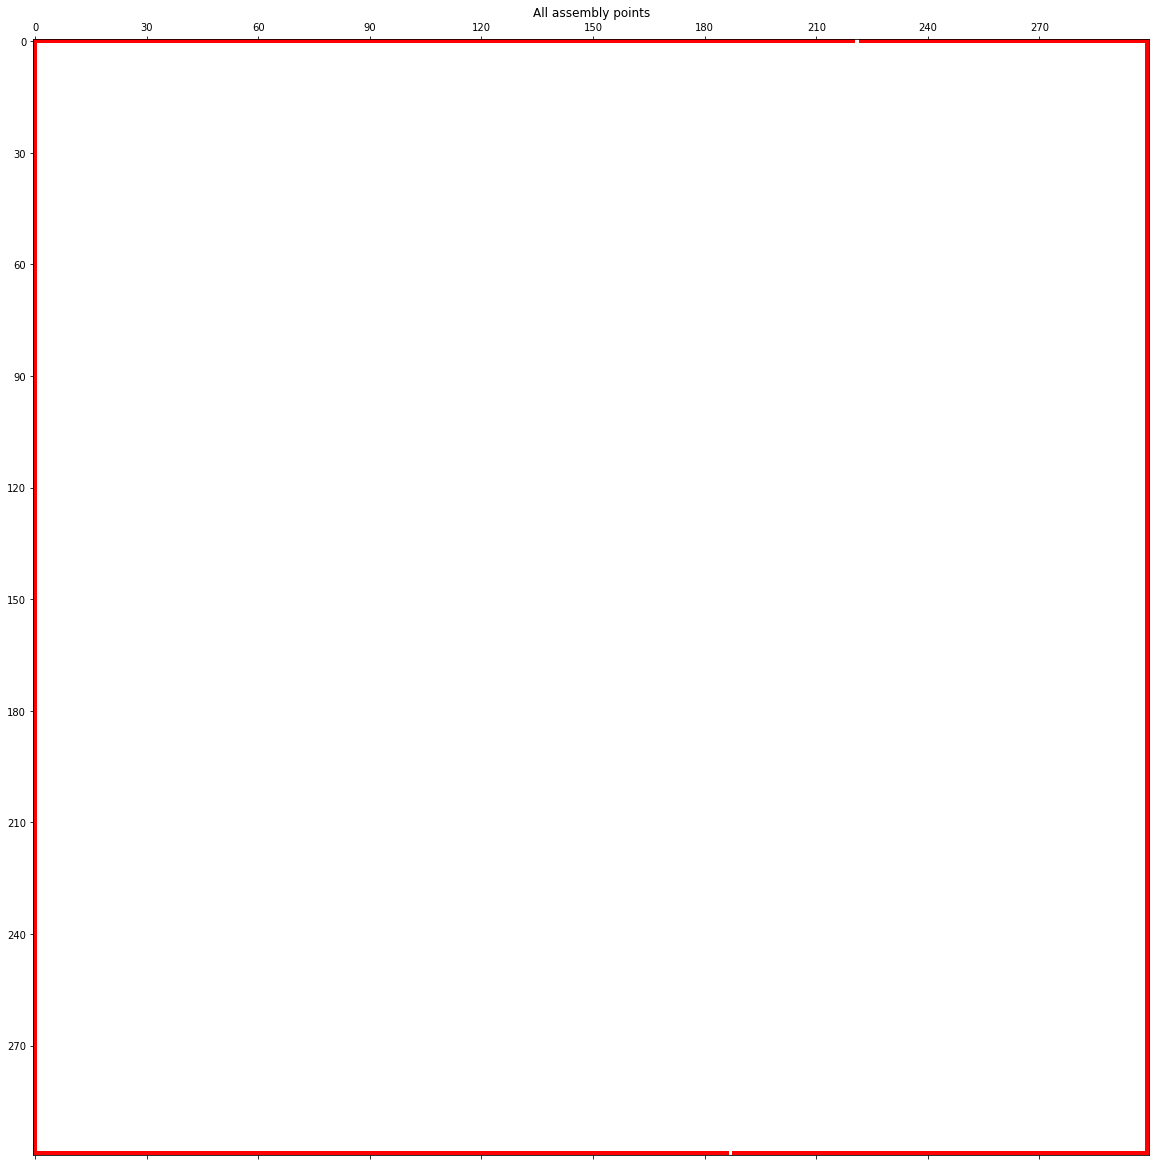

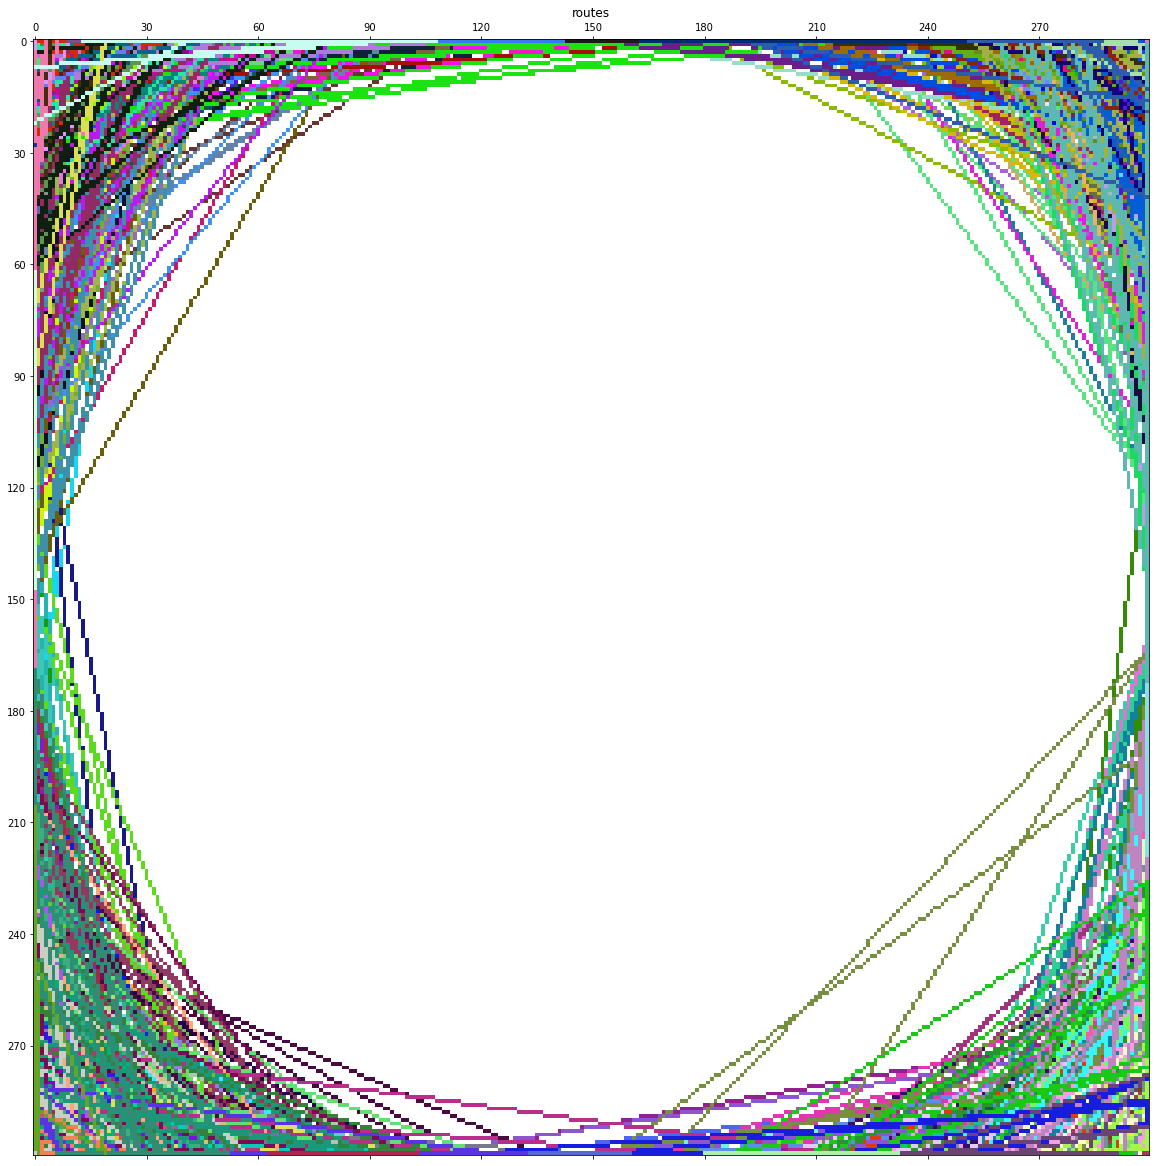




DISRIBUTION OF SCORES BETWEEN TESTS:
A 16 0.00%
B 1070068 9.08%
C 3527457 29.92%
D 2594117 22.00%
E 1105254 9.38%
F 3491888 29.62%


In [70]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from collections import Counter
from itertools import chain

def read_mount_points(n, f):
    points = []
    for _ in range(n): 
        x, y = list(map(int, f.readline().strip().split()))
        points.append((x, y))
    return points

def draw_points(w, h, points, desc):
    nrows, ncols = w,h
    image = np.ones((nrows, ncols, 3), np.uint8) * 255

    # Set every other cell to a random number (this would be your data)
    for x, y in points:
        image[x][y] = (255, 0, 0)

    row_labels = range(0, nrows, max(w // 10, 1) )
    col_labels = range(0, ncols, max(h // 10, 1) )

    
    plt.matshow(image)
    plt.title(desc)
    plt.xticks(col_labels, col_labels)
    plt.yticks(row_labels, row_labels)
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    plt.show()
    
def read_tasks(n_tasks, f):
    tasks = []
    for i in range(n_tasks):
        score, n_points = list(map(int, f.readline().strip().split()))
        points_flat = list(map(int, f.readline().strip().split()))
        points = [(points_flat[2*i], points_flat[2*i+1]) for i in range(n_points)]
        tasks.append( (score, points))
    return tasks

def find_closest_mp(point, all_points):
    dists = [point[0] - mp[0] + point[1] - mp[1] for mp in all_points]
    return all_points[np.argmin(dists)]

def get_task_length(task, mount_points):
    s = 0
    x, y = find_closest_mp(task[1][0], mount_points)
    for new_x, new_y in task[1]:
        s += abs(new_x - x) + abs(new_y - y)
        x = new_x
        y = new_y
    return s

def draw_line(image, color, s, f):
    mat = image
    x0, y0 = s
    x1, y1 = f
    
    # pimpl
    if not (0 <= x0 < mat.shape[0] and 0 <= x1 < mat.shape[0] and
            0 <= y0 < mat.shape[1] and 0 <= y1 < mat.shape[1]):
        raise ValueError('Invalid coordinates.')
    if (x0, y0) == (x1, y1):
        mat[x0, y0] = color
        return
    # Swap axes if Y slope is smaller than X slope
    transpose = abs(x1 - x0) < abs(y1 - y0)
    if transpose:
        mat = mat.transpose(1, 0, 2)
        x0, y0, x1, y1 = y0, x0, y1, x1
    # Swap line direction to go left-to-right if necessary
    if x0 > x1:
        x0, y0, x1, y1 = x1, y1, x0, y0
    # Write line ends
    mat[x0, y0] = color
    mat[x1, y1] = color
    # Compute intermediate coordinates using line equation
    x = np.arange(x0 + 1, x1)
    y = np.round(((y1 - y0) / (x1 - x0)) * (x - x0) + y0).astype(x.dtype)
    # Write intermediate coordinates
    mat[x, y] = color

def draw_routes(width, height, tasks, mount_points):
    nrows, ncols = width,height
    colors = [list(np.random.choice(range(256), size=3)) for _ in range(len(tasks))]
    image = np.ones((width, height, 3), np.uint8) * 255
    for task, color in zip(tasks, colors):
        old_point = task[1][0] # find_closest_mp(task[1][0], mount_points)
        for new_point in task[1]:
            draw_line(image, color, old_point, new_point)
            old_point = new_point
    
    row_labels = range(0, nrows, max(width // 10, 1) )
    col_labels = range(0, ncols, max(height // 10, 1) )
    plt.matshow(image)
    plt.title("routes")
    plt.xticks(col_labels, col_labels)
    plt.yticks(row_labels, row_labels)
    fig = plt.gcf()
    fig.set_size_inches(20, 20)

    plt.show()

def analyze_file(f):
    
    width, height, total_arms, total_mount_points, n_tasks, n_steps = list(map(int, f.readline().strip().split()))
    
    print("World: {}x{}, {} steps".format(width, height, n_steps))
    print("Tasks number:", n_tasks)
    print("Arms number:", total_arms)
    print("Mount points number:", total_mount_points)
    
    mount_points = read_mount_points(total_mount_points, f)
    
    tasks = read_tasks(n_tasks, f)
    scores = list(map(lambda x: x[0], tasks))
    points = list(map(lambda x: len(x[1]), tasks))
    
    sum_scores = sum(scores)
    sum_tasks_points = sum(points)
    
    lengths = list(map(lambda x: get_task_length(x, mount_points), tasks))
    
    print("Sum of scores (max score): ", sum_scores)
    print("Average task score:", sum_scores / n_tasks)
    
    print("Sum of task assembly points number: ", sum_tasks_points)
    print("Average assembly points number: ", sum_tasks_points / n_tasks)
    
    print("Average task route length (L1 sum + dist to closest MP):", sum(lengths) / n_tasks)
    
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 16))
    axs[0][0].set_title("Distribution of task scores")
    axs[0][0].hist(scores, bins=min(100, len(scores)+1))
    
    axs[0][1].set_title("Distribution of assembly points number")
    axs[0][1].hist(points, bins=min(100, len(points)+1))
    
    axs[1][0].set_title("Distribution of task route lengths")
    axs[1][0].hist(lengths, bins=min(100, len(lengths)+1))

    values = [s / l for s, l in zip(scores, lengths)]
    axs[1][1].set_title("Distribution score / route length (values):")
    axs[1][1].hist(values, bins=min(100, len(values)+1))
    
    
    draw_points(width, height, mount_points,
                "Mount points_distribution")
    assembly_points_flat = sum(map(lambda x: x[1], tasks), [])
    
    draw_points(width, height, assembly_points_flat, "All assembly points")
    
    draw_routes(width, height, tasks, mount_points)
    return sum_scores

    
def analyze():
    max_scores = {}
    for filename in sorted(os.listdir("test")):
        if filename.endswith(".in"):
            with open(os.path.join('test', filename)) as f:
                print("-" * 30)
                print("Stats for {}".format(filename))
                max_score = analyze_file(f)
                max_scores[filename.split('.')[0]] = max_score
                print('\n'*2)
                
    print("DISRIBUTION OF SCORES BETWEEN TESTS:")
    sum_max_scores = sum(max_scores.values())
    for k, v in max_scores.items():
        print(k.upper(), v, "{:.2f}%".format(v / sum_max_scores * 100))

analyze()